# Step 1
Download and setup the `DUTS-TR` dataset to train on. This also downloads a sample image of the space needle, and a video of a duck for evaluation.

In [ ]:
!mkdir -p data
!wget http://saliencydetection.net/duts/download/DUTS-TR.zip
!wget https://github.com/patrickisroman/u2net-tensorflow/raw/master/examples/space.jpg
!wget https://github.com/patrickisroman/u2net-tensorflow/raw/master/examples/duck.mp4
!unzip DUTS-TR.zip -d data

# Step 2

Import the model. This is the same as including `model/u2net.py`

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, ReLU, MaxPool2D, UpSampling2D

class ConvBlock(keras.layers.Layer):
    def __init__(self, out_ch=3,dirate=1):
        super(ConvBlock, self).__init__()
        self.conv = Conv2D(out_ch, (3, 3), strides=1, padding='same', dilation_rate=dirate)
        self.bn = BatchNormalization()
        self.relu = ReLU()
    
    def call(self, inputs):
        hx = inputs

        x = self.conv(hx)
        x = self.bn(x)
        x = self.relu(x)

        return x

class RSU7(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=1)
        self.pool4   = MaxPool2D(2, strides=(2, 2))

        self.conv_b5 = ConvBlock(mid_ch, dirate=1)
        self.pool5   = MaxPool2D(2, strides=(2, 2))

        self.conv_b6 = ConvBlock(mid_ch, dirate=1)
        self.conv_b7 = ConvBlock(mid_ch, dirate=2)

        self.conv_b6_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b5_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b4_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b3_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d  = ConvBlock(mid_ch, dirate=1)
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d  = ConvBlock(out_ch, dirate=1)
        self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)
        hx = self.pool3(hx3)

        hx4 = self.conv_b4(hx)
        hx = self.pool4(hx4)

        hx5 = self.conv_b5(hx)
        hx = self.pool5(hx5)

        hx6 = self.conv_b6(hx)

        hx7 = self.conv_b7(hx6)

        hx6d = self.conv_b6_d(tf.concat([hx7, hx6], axis=3))
        hx6dup = self.upsample_5(hx6d)

        hx5d = self.conv_b5_d(tf.concat([hx6dup, hx5], axis=3))
        hx5dup = self.upsample_4(hx5d)

        hx4d = self.conv_b4_d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)

        hx3d = self.conv_b3_d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU6(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=1)
        self.pool4   = MaxPool2D(2, strides=(2, 2))

        self.conv_b5 = ConvBlock(mid_ch, dirate=1)
        self.pool5   = MaxPool2D(2, strides=(2, 2))

        self.conv_b6 = ConvBlock(mid_ch, dirate=2)

        self.conv_b5_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b4_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b3_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)
        hx = self.pool3(hx3)

        hx4 = self.conv_b4(hx)
        hx = self.pool4(hx4)

        hx5 = self.conv_b5(hx)

        hx6 = self.conv_b6(hx5)

        hx5d = self.conv_b5_d(tf.concat([hx6, hx5], axis=3))
        hx5dup = self.upsample_4(hx5d)

        hx4d = self.conv_b4_d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)

        hx3d = self.conv_b3_d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU5(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=1)
        self.pool4   = MaxPool2D(2, strides=(2, 2))

        self.conv_b5 = ConvBlock(mid_ch, dirate=2)

        self.conv_b4_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b3_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)
        hx = self.pool3(hx3)

        hx4 = self.conv_b4(hx)

        hx5 = self.conv_b5(hx4)

        hx4d = self.conv_b4_d(tf.concat([hx5, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)

        hx3d = self.conv_b3_d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU4(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)

        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.pool1   = MaxPool2D(2, strides=(2, 2))

        self.conv_b2 = ConvBlock(mid_ch, dirate=1)
        self.pool2   = MaxPool2D(2, strides=(2, 2))

        self.conv_b3 = ConvBlock(mid_ch, dirate=1)
        self.pool3   = MaxPool2D(2, strides=(2, 2))

        self.conv_b4 = ConvBlock(mid_ch, dirate=2)

        self.conv_b3_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b2_d = ConvBlock(mid_ch, dirate=1)
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)

        hx1 = self.conv_b1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.conv_b2(hx)
        hx = self.pool2(hx2)

        hx3 = self.conv_b3(hx)

        hx4 = self.conv_b4(hx3)

        hx3d = self.conv_b3_d(tf.concat([hx4, hx3], axis=3))
        hx3dup = self.upsample_2(hx3d)

        hx2d =  self.conv_b2_d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_1(hx2d)

        hx1d = self.conv_b1_d(tf.concat([hx2dup, hx1], axis=3))
        
        return hx1d + hxin

class RSU4F(keras.layers.Layer):
    def __init__(self, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()
        self.conv_b0 = ConvBlock(out_ch, dirate=1)
        self.conv_b1 = ConvBlock(mid_ch, dirate=1)
        self.conv_b2 = ConvBlock(mid_ch, dirate=2)
        self.conv_b3 = ConvBlock(mid_ch, dirate=4)
        self.conv_b4 = ConvBlock(mid_ch, dirate=8)
        self.conv_b3_d = ConvBlock(mid_ch, dirate=4)
        self.conv_b2_d = ConvBlock(mid_ch, dirate=2)
        self.conv_b1_d = ConvBlock(out_ch, dirate=1)
    
    def call(self, inputs):
        hx = inputs
        hxin = self.conv_b0(hx)
        
        hx1 = self.conv_b1(hxin)
        hx2 = self.conv_b2(hx1)
        hx3 = self.conv_b3(hx2)
        hx4 = self.conv_b4(hx3)
        hx3d = self.conv_b3_d(tf.concat([hx4, hx3], axis=3))
        hx2d = self.conv_b2_d(tf.concat([hx3d, hx2], axis=3))
        hx1d = self.conv_b1_d(tf.concat([hx2d, hx1], axis=3))
        return hx1d + hxin

class U2NET(keras.models.Model):
    def __init__(self, out_ch=1):
        super(U2NET, self).__init__()
        
        self.stage1 = RSU7(32, 64)
        self.pool12 = MaxPool2D((2, 2), 2)

        self.stage2 = RSU6(32, 128)
        self.pool23 = MaxPool2D((2, 2), 2)

        self.stage3 = RSU5(64, 256)
        self.pool34 = MaxPool2D((2, 2), 2)

        self.stage4 = RSU4(128, 512)
        self.pool45 = MaxPool2D((2, 2), 2)

        self.stage5 = RSU4F(256, 512)
        self.pool56 = MaxPool2D((2, 2), 2)

        self.stage6 = RSU4F(256, 512)

        self.stage5d = RSU4F(256, 512)
        self.stage4d = RSU4(128, 256)
        self.stage3d = RSU5(64, 128)
        self.stage2d = RSU6(32, 64)
        self.stage1d = RSU7(16, 64)

        self.side1 = Conv2D(out_ch, (3, 3), padding='same')
        self.side2 = Conv2D(out_ch, (3, 3), padding='same')
        self.side3 = Conv2D(out_ch, (3, 3), padding='same')
        self.side4 = Conv2D(out_ch, (3, 3), padding='same')
        self.side5 = Conv2D(out_ch, (3, 3), padding='same')
        self.side6 = Conv2D(out_ch, (3, 3), padding='same')

        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.upsample_out_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_out_3 = UpSampling2D(size=(4, 4), interpolation='bilinear')
        self.upsample_out_4 = UpSampling2D(size=(8, 8), interpolation='bilinear')
        self.upsample_out_5 = UpSampling2D(size=(16, 16), interpolation='bilinear')
        self.upsample_out_6 = UpSampling2D(size=(32, 32), interpolation='bilinear')

        self.outconv = Conv2D(out_ch, (1, 1), padding='same')
    
    def call(self, inputs):
        hx = inputs

        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        hx6up = self.upsample_1(hx6)
        side6 = self.upsample_out_6(self.side6(hx6))

        hx5d = self.stage5d(tf.concat([hx6up, hx5], axis=3))
        hx5dup = self.upsample_2(hx5d)
        side5 = self.upsample_out_5(self.side5(hx5d))

        hx4d = self.stage4d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_3(hx4d)
        side4 = self.upsample_out_4(self.side4(hx4d))

        hx3d = self.stage3d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_4(hx3d)
        side3 = self.upsample_out_3(self.side3(hx3d))

        hx2d = self.stage2d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_5(hx2d)
        side2 = self.upsample_out_2(self.side2(hx2d))

        hx1d = self.stage1d(tf.concat([hx2dup, hx1], axis=3))
        side1 = self.side1(hx1d)

        fused_output = self.outconv(tf.concat([side1, side2, side3, side4, side5, side6], axis=3))

        sig = keras.activations.sigmoid
        return tf.stack([sig(fused_output), sig(side1), sig(side2), sig(side3), sig(side4), sig(side5), sig(side6)])

class U2NETP(keras.models.Model):
    def __init__(self, out_ch=1):
        super(U2NETP, self).__init__()

        self.stage1 = RSU7(16, 64)
        self.pool12 = MaxPool2D((2, 2), 2)

        self.stage2 = RSU6(16, 64)
        self.pool23 = MaxPool2D((2, 2), 2)

        self.stage3 = RSU5(16, 64)
        self.pool34 = MaxPool2D((2, 2), 2)

        self.stage4 = RSU4(16, 64)
        self.pool45 = MaxPool2D((2, 2), 2)

        self.stage5 = RSU4F(16, 64)
        self.pool56 = MaxPool2D((2, 2), 2)

        self.stage6 = RSU4F(16, 64)
        self.side6 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage5d = RSU4F(16, 64)
        self.side5 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage4d = RSU4(16, 64)
        self.side4 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage3d = RSU5(16, 64)
        self.side3 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage2d = RSU6(16, 64)
        self.side2 = Conv2D(out_ch, (3, 3), padding='same')

        self.stage1d = RSU7(16, 64)
        self.side1 = Conv2D(out_ch, (3, 3), padding='same')

        self.upsample_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_5 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_6 = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.upsample_out_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_out_3 = UpSampling2D(size=(4, 4), interpolation='bilinear')
        self.upsample_out_4 = UpSampling2D(size=(8, 8), interpolation='bilinear')
        self.upsample_out_5 = UpSampling2D(size=(16, 16), interpolation='bilinear')
        self.upsample_out_6 = UpSampling2D(size=(32, 32), interpolation='bilinear')

        self.outconv = Conv2D(out_ch, 1)
    
    def call(self, inputs):
        hx = inputs
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        hx6up = self.upsample_6(hx6)
        side6 = self.upsample_out_6(self.side6(hx6))

        hx5d = self.stage5d(tf.concat([hx6up, hx5], axis=3))
        hx5dup = self.upsample_5(hx5d)
        side5 = self.upsample_out_5(self.side5(hx5d))

        hx4d = self.stage4d(tf.concat([hx5dup, hx4], axis=3))
        hx4dup = self.upsample_4(hx4d)
        side4 = self.upsample_out_4(self.side4(hx4d))

        hx3d = self.stage3d(tf.concat([hx4dup, hx3], axis=3))
        hx3dup = self.upsample_3(hx3d)
        side3 = self.upsample_out_3(self.side3(hx3d))

        hx2d = self.stage2d(tf.concat([hx3dup, hx2], axis=3))
        hx2dup = self.upsample_2(hx2d)
        side2 = self.upsample_out_2(self.side2(hx2d))

        hx1d = self.stage1d(tf.concat([hx2dup, hx1], axis=3))
        side1 = self.side1(hx1d)

        fused_output = self.outconv(tf.concat([side1, side2, side3, side4, side5, side6], axis=3))

        sig = keras.activations.sigmoid
        return tf.stack([sig(fused_output), sig(side1), sig(side2), sig(side3), sig(side4), sig(side5), sig(side6)])

# Step 3
Define the loss function. [The paper](https://arxiv.org/pdf/2005.09007.pdf) defines the loss function as the sum of the binary crossentropy between each of the 6 sides and the ground truth, and the fused output and the ground truth, for a total of 7 equally weighted BCE terms:

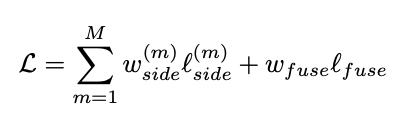

Each layer in the network outputs a mask (side) of varying spatio-semantic value, which are all computed against the GT and weighted equally in the loss. Finally, a supposition (weighted sum) of these 6 sides is taken at each pixel with a 1x1x6 convolution, creating the fused output:

`d0 = self.outconv(tf.concat([d1, d2, d3, d4, d5, d6], axis=3))`

The fused output has its binary crossentropy taken, and is used as the last term in the loss function. When evaluating the network, the sides are ignored and only the fused output is salient.

In [ ]:
bce = keras.losses.BinaryCrossentropy()

def bce_loss(y_true, y_pred):
    y_p = tf.expand_dims(y_pred, axis=-1)
    loss0 = bce(y_true, y_p[0])
    loss1 = bce(y_true, y_p[1])
    loss2 = bce(y_true, y_p[2])
    loss3 = bce(y_true, y_p[3])
    loss4 = bce(y_true, y_p[4])
    loss5 = bce(y_true, y_p[5])
    loss6 = bce(y_true, y_p[6])
    return loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

# Step 4

Define config variables for training. This is the same as including `config.py`

In [ ]:
import pathlib

# Model
default_in_shape = (320, 320, 3)
default_out_shape = (320, 320, 1)
checkpoint_path = 'weights.ht5'

# Training
batch_size = 10
epochs = 5000
learning_rate = 0.0001
eval_interval = 100
weights_save_interval = 500

# Dataset 
root_data_dir = pathlib.Path('data')
dataset_dir = root_data_dir.joinpath('DUTS-TR')
image_dir = dataset_dir.joinpath('DUTS-TR-Image')
mask_dir = dataset_dir.joinpath('DUTS-TR-Mask')

# Model type
# By default, the regular sized model (U2NET) is used in this notebook.
# Set this to True if you want to use the condensed model (U2NETP)
use_tiny_model = False

# Step 5

Define the dataloader. This is the same as including `dataloader.py`. The dataloader loads a sample of images (default batch size is 12), resizes them to the network's input size (320, 320, 3), randomly augments them, and scales them from [0-255] to [0-1] to prepare them for the network.

In [ ]:
# Dataloader methods (dataloader.py)

import os
import random
import numpy as np
import zipfile

from PIL import Image 

input_files = os.listdir(image_dir)

def get_image_mask_pair(img_name, in_resize=None, out_resize=None):
    img  = Image.open(image_dir.joinpath(img_name))
    mask = Image.open(mask_dir.joinpath(img_name.replace('jpg', 'png')))

    if in_resize:
        img = img.resize(in_resize[:2], Image.BICUBIC)
    
    if out_resize:
        mask = mask.resize(out_resize[:2], Image.BICUBIC)
    
    if bool(random.getrandbits(1)):
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

    return (np.asarray(img, dtype=np.float32), np.expand_dims(np.asarray(mask, dtype=np.float32), -1))

def load_training_batch(batch_size=16, in_shape=default_in_shape, out_shape=default_out_shape):
    imgs = random.choices(input_files, k=batch_size)
    image_list = [get_image_mask_pair(img, in_resize=default_in_shape, out_resize=default_out_shape) for img in imgs]
    
    tensor_in  = np.stack([i[0]/255. for i in image_list])
    tensor_out = np.stack([i[1]/255. for i in image_list])
    
    return (tensor_in, tensor_out)

# Step 6

We're now ready to build and compile the model so we can begin training.

In [ ]:
# Build the network
adam = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=.9, beta_2=.999, epsilon=1e-08)
inputs = keras.Input(shape=default_in_shape)
net = U2NETP() if use_tiny_model else U2NET()
out = net(inputs)
model = keras.Model(inputs=inputs, outputs=out, name='u2netmodel')
model.compile(optimizer=adam, loss=bce_loss, metrics=None)

# Print summary
model.summary()

# Step 7

Open the PIL image and convert into a tensor that can be used on the network.

In [ ]:

import io
import base64
from IPython.display import HTML
import matplotlib.pyplot as plt

def format_input(input_image):
  assert(input_image.size == default_in_shape[:2] or input_image.shape == default_in_shape)
  return np.expand_dims(np.array(input_image)/255., 0)

# Load test image
im = Image.open('./img_test/roses.jpg')
im = im.resize(default_in_shape[:2])
image = format_input(im)
image.shape

# Step 8

Training can now begin. Iteratively sample `batch_size` images and train the network.

In [ ]:
# train and show progress

for e in range(epochs):
    try:
      feed, out = load_training_batch(batch_size=batch_size)
      loss = model.train_on_batch(feed, out)

      if e % weights_save_interval == 0:
        model.save(checkpoint_path)

      if e % eval_interval == 0:
        print('[%s] Loss: %s' % (e, str(loss)))
        out = model(image)
        f, a = plt.subplots(1,9,figsize=(27, 3))
        a[0].imshow(image[0])
        a[1].imshow(np.multiply(image[0], np.tile(out[0][0], [1, 1, 3])))
        a[2].imshow(np.tile(out[0][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[3].imshow(np.tile(out[1][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[4].imshow(np.tile(out[2][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[5].imshow(np.tile(out[3][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[6].imshow(np.tile(out[4][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[7].imshow(np.tile(out[5][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
        a[8].imshow(np.tile(out[6][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)

        a[0].set_title('Input Image')
        a[1].set_title('Masked Image')
        a[2].set_title('Fused Output Mask')
        for i, ax in enumerate(a[3:]):
          ax.set_title('Side %d Output' % (i+1))
          
        plt.show()
    except KeyboardInterrupt:
      pass
    except ValueError:
      pass


# predict

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.load_weights('myModel.h5')

In [ ]:
# Load test image
im = Image.open('ILSVRC2012_test_00000022.jpg')
im = im.resize(default_in_shape[:2])
image = format_input(im)

In [ ]:
out = model(image)

In [ ]:
out.shape

In [ ]:
f, a = plt.subplots(1,2,figsize=(25, 25))
a[0].imshow(image[0])
a[1].imshow(np.multiply(image[0], np.tile(out[0][0], [1])))